# Predicting Income from Census Data
**Author:** <u>Tristan Joshua B. Alba</u>  
Asian Institute of Management, MS Data Science 2019  


<img src="census-money-image.png" alt="money">

## Executive Summary

This document presents the analysis and implementation of machine learning algorithms to predict the income bracket (exceeding \$50K USD per year or not) using census data information. Both KNearest Neighbors and Decision Tree Classification achieved test accuracies greater than 1.25 times the proportional chance criterion. Tuning the maximum depth of the decision tree reduced overfitting and yielded the current highest test accuracy of 85.17% for 100 trials.

#### Highlights of the Results
- Continuous features like `age, education-num, capital-gain, capital-loss`, and `fnlwgt` correlated most with `income` target variable
- KNearest Neighbor classifier with -- number of neighbors achieved acceptable test scores of 78.94%.
- Decision Trees classifier with `max_depth = 10` yielded the highest test score of 85.17%

## About the Data

The data used in this experiment was the 1994 US Census Income dataset obtained from UCI Machine Learning Repository <https://archive.ics.uci.edu/ml/datasets/census+income>. It is a relatively clean multivariate dataset containing attributes of more than 30,000 individuals, each with attached labels if they have incomes <=50K or >50K. The table below shows the type, and the values each attribute takes. 

|Attribute| Type | Values| 
|:-------|:------|:------|
|Age| continuous | | 
|Workclass| categorical | Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked | 
|Fnlwgt| continuous | | 
|Education| categorical | Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool | 
|Education-num| continuous |
|Marital-status| categorical | Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse|
|Occupation| categorical | Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces | 
|Relationship| categorical | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried | 
|Race| categorical |White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
|Sex| categorical | Female, Male |
|Capital-gain| continuous| |
|Capital-loss| continuous| | 
|Hours-per-week| continuous|  | 
|Native-country| categorical | United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US (Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands |


In [593]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [594]:
import pandas as pd
df = pd.read_csv("census_data.csv", header = 0, names = ['age', 'workclass',
                'Fnlwgt','Education','Education-num','Marital-status',
                'Occupation','Relationship','Race','Sex','Capital-gain',
                'Capital-loss','Hours-per-week','Native-country','Income'])

In [595]:
df.head(3)

,age,workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


### Checking for null and wrong input values

Upon checking the data, it appears that are some cells populated with `' ?'` perhaps because the attribute data was not available for the individual at the time of collection. Indices of rows containing incomplete data are identified and dropped from the dataset.

In [596]:
df.iloc[26,1]

' ?'

In [597]:
pd.notnull(df[df==' ?']).any()

age               False
workclass          True
Fnlwgt            False
Education         False
Education-num     False
Marital-status    False
Occupation         True
Relationship      False
Race              False
Sex               False
Capital-gain      False
Capital-loss      False
Hours-per-week    False
Native-country     True
Income            False
dtype: bool

In [598]:
for i in ['workclass','Occupation','Native-country']:
    df.drop(df[df[i]==' ?'].index, axis = 0, inplace= True)
pd.notnull(df[df==' ?']).any()

age               False
workclass         False
Fnlwgt            False
Education         False
Education-num     False
Marital-status    False
Occupation        False
Relationship      False
Race              False
Sex               False
Capital-gain      False
Capital-loss      False
Hours-per-week    False
Native-country    False
Income            False
dtype: bool

In [599]:
df.isnull().values.any()

False

In [600]:
df.shape

(30161, 15)

The Census Income Dataset contains 30,161 rows and 15 columns, without any null and wrong input i.e. `' ?'` values

### Checking for data types for each attributes

In [601]:
df.dtypes

age                int64
workclass         object
Fnlwgt             int64
Education         object
Education-num      int64
Marital-status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital-gain       int64
Capital-loss       int64
Hours-per-week     int64
Native-country    object
Income            object
dtype: object

### Encoding categorical variables

Given that the dataset contains features that are categorical in nature, these have to be encoded properly before analysis. First, the nominal and ordinal categorical features are separated. Based on some knowledge on the potential relationship of the features to the income of an individual, features like `Education` and `Occupation` are treated as ordinal features; while, `'workclass', 'Marital-status','Relationship','Race','Sex', and 'Native-country'` are considered as nominal features. Dummy variables and numerical codes were derived from the nominal and ordinal categorical features, respectively.

In [602]:
df_ = df

nom_cat_feat = ['workclass', 'Marital-status','Relationship','Race','Sex','Native-country']

ord_cat_feat = ['Education','Occupation']

educ_cat = [' Preschool',' 1st-4th',' 5th-6th',' 7th-8th',' 9th',' 10th',' 11th',
                ' 12th',' HS-grad',' Assoc-voc',' Assoc-acdm',' Some-college',' Bachelors',
                ' Prof-school',' Masters',' Doctorate']

occup_cat = [' Farming-fishing',' Handlers-cleaners',' Transport-moving',' Machine-op-inspct',
             ' Priv-house-serv',' Craft-repair',' Tech-support',' Adm-clerical',
             ' Protective-serv',' Other-service',' Armed-Forces',
             ' Sales',' Prof-specialty',' Exec-managerial']

categories = [educ_cat,occup_cat]

for i in nom_cat_feat:
    df = pd.concat([df, pd.get_dummies(df[i])], axis=1)

for i in range(len(ord_cat_feat)):
    df[ord_cat_feat[i]] = df[ord_cat_feat[i]].astype("category", ordered=True, categories=categories[i]).cat.codes

df.drop(nom_cat_feat, axis = 1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


### Assigning features and target to feature and target vectors

In [606]:
X = df
y = df['Income']

X = X.drop(['Income'], axis = 1)

## Exploring the Data

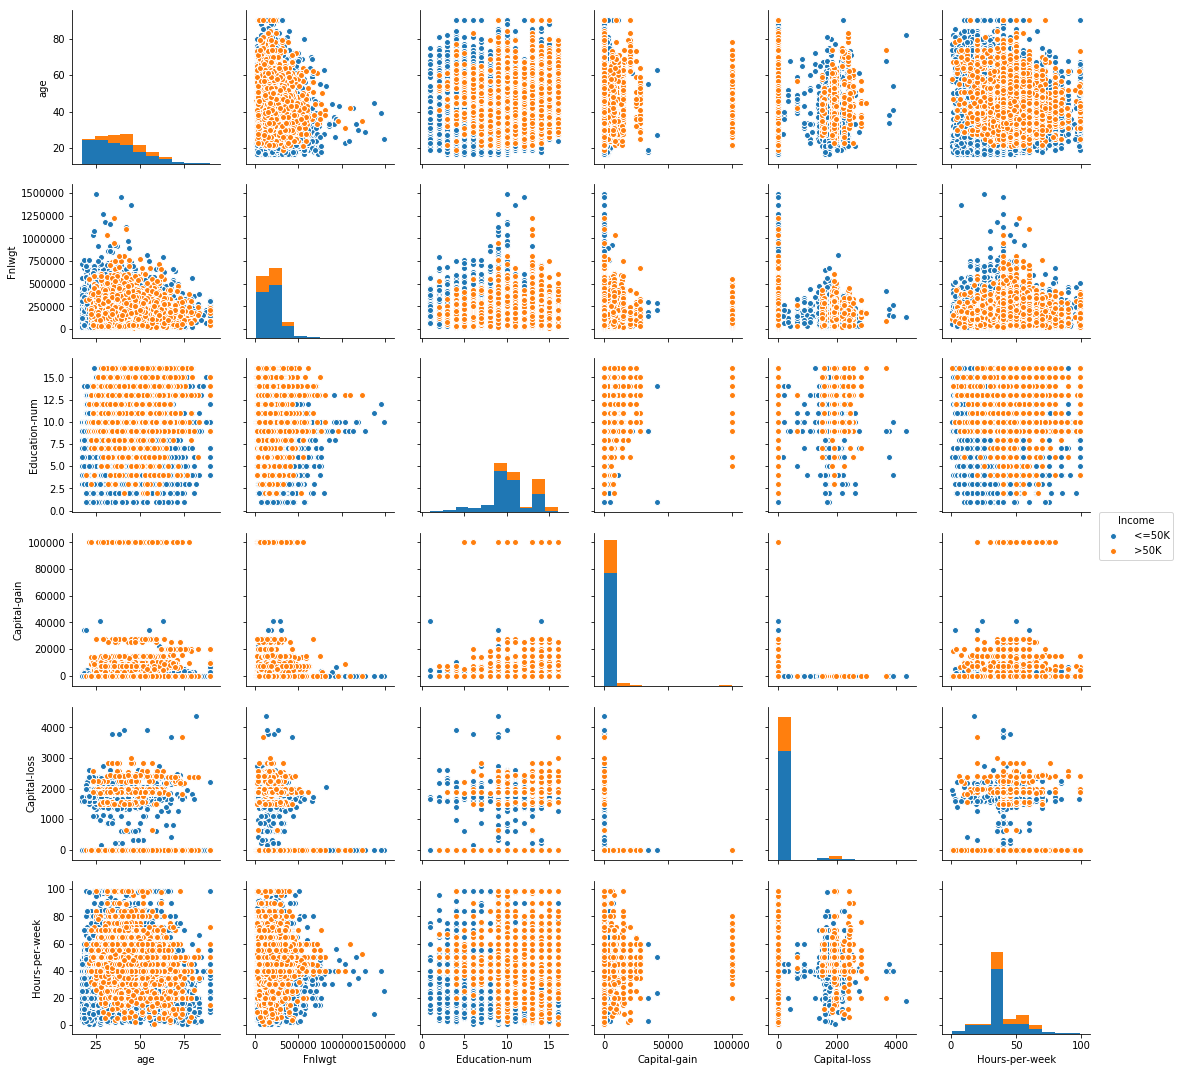

In [609]:
sns.pairplot(df_, hue='Income');

Some findings from the scattermatrix of continuous features:
1. **AGE:** Individuals with income >50K tend to be older.
2. **FNLWGT:** There are more individuals that possesses higher FNLWGT values with income >50K.
3. **EDUCATION-NUM:** Individuals with income >50K appears to spend more years in education.
4. **CAPITAL GAIN:** Clearly, individuals with income >50K have more capital gains.
5. **CAPITAL LOSS:** Similarly, individuals with income >50K have more capital losses.
6. **HOURS-PER-WEEK:** Lastly, individuals with income >50K seem to spend more hours per week at work.

This observation seems reasonable given that individuals with more experience--given their age, education level, and time spent at work, often earn more than those less experienced. Interestingly, people who spend more years in educating themselves tend to spend more hours-per-week at work. Perhaps, this is due to more responsibilities or opportunities given their bigger skillset. 

Furthermore, looking at the interdependence of other features, it is apparent that no conclusive relationships between them can be drawn. 

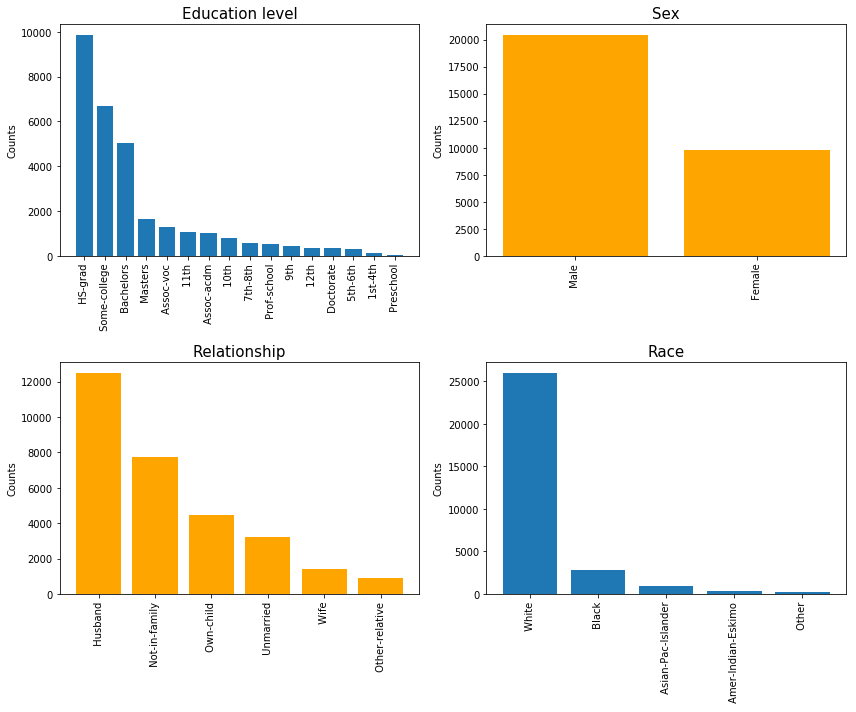

In [659]:
fig = plt.figure(figsize=(12,10))
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax0.bar(range(len(df_['Education'].value_counts())),df_['Education'].value_counts())
ax0.set_xticks(range(len(df_['Education'].value_counts())))
ax0.set_xticklabels(df_['Education'].value_counts().index.tolist(), rotation='90')
ax0.set_title('Education level', size = 15)
ax0.set_ylabel('Counts')

ax1.bar(range(len(df_['Sex'].value_counts())),df_['Sex'].value_counts(),color = 'orange')
ax1.set_xticks(range(len(df_['Sex'].value_counts())))
ax1.set_xticklabels(df_['Sex'].value_counts().index.tolist(), rotation='90')
ax1.set_title('Sex', size =15)
ax1.set_ylabel('Counts')

ax2.bar(range(len(df_['Relationship'].value_counts())),df_['Relationship'].value_counts(), color = 'orange')
ax2.set_xticks(range(len(df_['Relationship'].value_counts())))
ax2.set_xticklabels(df_['Relationship'].value_counts().index.tolist(), rotation='90')
ax2.set_title('Relationship', size =15)
ax2.set_ylabel('Counts')

ax3.bar(range(len(df_['Race'].value_counts())),df_['Race'].value_counts())
ax3.set_xticks(range(len(df_['Race'].value_counts())))
ax3.set_xticklabels(df_['Race'].value_counts().index.tolist(), rotation='90')
ax3.set_title('Race', size = 15)
ax3.set_ylabel('Counts')

plt.tight_layout()


Additionally, it would be interesting to look at some other categorical features with more depth, particularly those that might have some correlation to income for people residing in the United States.

- **EDUCATION LEVEL:** Given going to college isn't really a prerequisite to live a financially stable life in the United States, it was worth exploring the education level of individuals from the census data. It appears that most of the population possesses high school diplomas.
- **MARITAL STATUS:** Up until today, we hear of gender inequality reflected on salaries of individuals. In this plot, the number of males vs. females are plotted in a bargraph. The dataset contains more males than females. 
- **RELATIONSHIP:** Similarly, we hear the inequality for female members of the family. Here, the relationships taken by the individuals are shown.
- **RACE:** Controversially, the United States has been known fighting racism which has long reflected on their plight to eliminate racial discrimination in employment opportunities and salary grades for same positions offered to individuals. It could be seen that most individuals sampled were whites.

## Results of Analysis

With the objective to correctly label an individual's income depending on his or her attributes, the following classification algorithms were implemented on the Census Income Dataset:
1. KNearest Neighbors Classification
2. Decision Tree Classification

It is important that the proportional chance criterion be determined to evaluate the aptness of the subsequent classifiers. 

In [693]:
import numpy as np
from collections import Counter
state_counts = Counter(df['Income'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')

num=(df_state[0]/df_state[0].sum())**2
print("Population per class: {}\n".format(df_state))
print("1.25 * Proportion Chance Criterion: {}%".format(1.25*100*num.sum()))

Population per class:             0
 <=50K  22653
 >50K    7508

1.25 * Proportion Chance Criterion: 78.258943533765%


Given this, the subsequent KNN and Decision Tree classifiers must have accuracies greater than 78.26% in order to be considered as a good classifier.

### KNearest Neighbors Classification

In [415]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [689]:
def plot_n_neighbors_clf(feat, targ, title, nmax=70, step=10, max_rstate=100, test_size=0.25):
    
    training_accuracy = []
    test_accuracy = []
    training_std = []
    test_std = []
    n_neighbors_list = []
    neighbors_settings = range(1, nmax, step)
    random_states = range(1,max_rstate)

    for n_neighbors in neighbors_settings:
        knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, leaf_size=60)    
        train_acc_per_trial = []
        test_acc_per_trial = []
        
        for random_state in random_states:
            X_train, X_test, y_train, y_test = train_test_split(feat,
                                                        targ, 
                                                        test_size=test_size,
                                                        random_state=random_state)
            knn_clf.fit(X_train, y_train)
            
            train_acc_per_trial.append(knn_clf.score(X_train, y_train))
            test_acc_per_trial.append(knn_clf.score(X_test, y_test))
        
   
        training_accuracy.append(np.mean(train_acc_per_trial))
        test_accuracy.append(np.mean(test_acc_per_trial))
        training_std.append(np.std(train_acc_per_trial))
        test_std.append(np.std(test_acc_per_trial))
        n_neighbors_list.append(n_neighbors)

        
    results = pd.DataFrame([n_neighbors_list,training_accuracy, test_accuracy, 
                            training_std, test_std]).T
    
    results.columns = ['n_neighbors', 'mean train score', 'mean test score', 
                       'train std', 'test std']

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    ax.errorbar(neighbors_settings, training_accuracy, 
                 yerr=training_std, 
                 label="training accuracy" )
    ax.errorbar(neighbors_settings, test_accuracy, yerr=test_std, 
                 label="test accuracy" )
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("n_neighbors")
    ax.set_title(title)
    plt.legend()    
    return results, ax

,n_neighbors,mean train score,mean test score,train std,test std
0,1.0,0.999978,0.720395,0.000022,0.002851
1,3.0,0.860190,0.744861,0.002851,0.005967
2,5.0,0.829045,0.764554,0.000619,0.001658
3,7.0,0.815893,0.773903,0.001393,0.003183
4,9.0,0.808400,0.779804,0.000619,0.004575
5,11.0,0.805150,0.783252,0.000818,0.002851
6,13.0,0.803448,0.786965,0.000354,0.001392
7,15.0,0.801083,0.787362,0.000287,0.000862
8,17.0,0.798895,0.787893,0.000619,0.000995
9,19.0,0.798298,0.789153,0.000287,0.001459


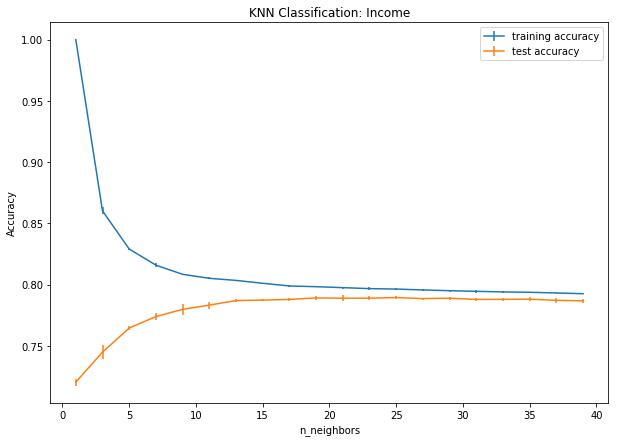

In [696]:
results, ax1 = plot_n_neighbors_clf(X, y, 'KNN Classification: Income', nmax=40, step=2, max_rstate=3, test_size=0.25)
ax1; results

**Observation:** The KNN classifier was able to achieve a mean train score of 79.63% and mean test score of 78.94% for 20 random trials. Based on the results, the optimal number of neighbors is 25 neighbors. Beyond this, there is a gradual drop in accuracies measured.

### Decision Trees Classification

In [678]:
def plot_dtrees_clf(feat, targ, title, max_rstate=100, test_size=0.25):
    
    training_accuracy = []
    test_accuracy = []
    training_std = []
    test_std = []
    random_states = range(1,max_rstate)

        
    for random_state in random_states:
        X_train, X_test, y_train, y_test = train_test_split(feat,
                                                    targ, 
                                                    test_size=test_size,
                                                    random_state=random_state)

        dtrees_clf = DecisionTreeClassifier(max_depth=10).fit(X_train, y_train)
            
        training_accuracy.append(dtrees_clf.score(X_train, y_train))
        test_accuracy.append(dtrees_clf.score(X_test, y_test))
        
        training_std.append(np.std(dtrees_clf.score(X_train, y_train)))
        test_std.append(np.std((dtrees_clf.score(X_test, y_test))))

        
    results = pd.DataFrame([max_rstate, np.mean(training_accuracy), np.mean(test_accuracy), 
                            np.std(training_accuracy), np.std(test_accuracy)]).T
    
    results.columns = ['trials', 'mean train score', 'mean test score', 
                       'train std', 'test std']
    

    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    ax.errorbar(random_states, training_accuracy, 
                 yerr=training_std, 
                 label="training accuracy" )
    ax.errorbar(random_states, test_accuracy, yerr=test_std, 
                 label="test accuracy" )
    ax.plot(random_states,np.ones(len(random_states))*np.mean(test_accuracy),"--" ,
           label='mean test accuracy')
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Trials")
    ax.set_title(title)
    plt.legend()    
    return results, ax

,trials,mean train score,mean test score,train std,test std
0,100.0,0.871525,0.851775,0.001322,0.00385


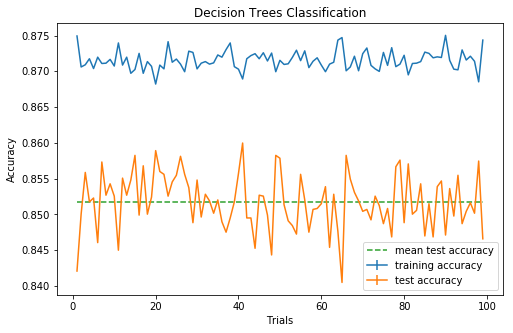

In [687]:
results, ax2 = plot_dtrees_clf(X, y, 'Decision Trees Classification', max_rstate=100, test_size=0.25)
ax2; results

**Observation:** The decision tree classifier was able to achieve a mean train score of 87.15% and mean test score of 85.17% for 100 random trials. Reducing the max depth the tree will keep on splitting reduced the overfitting of the model. This increased the test accuracy from ~81% to the current value. 

## Summary

Given the attributes taken from the Census Income dataset, the income bracket whether they have >50K per year income or otherwise can be reliably predicted by both KNearest Neighbors and Decision Tree Classifiers. With a proportional chance criterion given by the distribution of the data, both resultant models can be considered as good classifiers with their test accuracies yielding 78.94% and 85.17%, respectively. It appears that continuous features like age, number of years in education, capital loss, capital gain, and fnlwgt correlates most with the desired target. Knowledge of this predictive capability using the given set of individual's attributes would be useful for the government for designing social security programs and equitable income policies and for private financial institutions in crafting products like loans and insurance. 

## References
<sup>[1]</sup> Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.